# LJ, NPT

In [1]:
import sys, os
import glob

import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from thermoextrap.gpr_active import active_utils
from run_active_LJ_NPT import DataWrapPsat, DensityGPModel

2022-11-17 22:59:10.587657: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preliminaries

In [4]:
raw_dat = np.loadtxt('SRS_data/SRS_LJ_VLE_data.txt')
raw_beta = 1.0 / raw_dat[::-1, 0]
raw_psat = raw_dat[::-1, 5]
raw_lnpsat = np.log(raw_psat)
raw_dens = raw_dat[::-1, [1, 3]]
raw_dU = raw_dat[::-1, 7] - raw_dat[::-1, 9]
raw_pdv = raw_psat*((1/raw_dens[:, 0]) - (1/raw_dens[:, 1]))
raw_dlnpsatdbeta = -(raw_dU + raw_pdv) / (raw_beta*raw_pdv)

gt_lnpsat = interpolate.UnivariateSpline(raw_beta, raw_lnpsat, k=3, s=0)
gt_dlnpsatdbeta = interpolate.UnivariateSpline(raw_beta, raw_dlnpsatdbeta, k=3, s=0)
gt_dens_lo = interpolate.UnivariateSpline(raw_beta, raw_dens[:, 0], k=3, s=0)
gt_dens_hi = interpolate.UnivariateSpline(raw_beta, raw_dens[:, 1], k=3, s=0)
gt_dens = [gt_dens_lo, gt_dens_hi]

In [5]:
#Function to easily load data
def load_data(dir_name, beta_list):
    data_list = []
    
    for i, beta in enumerate(beta_list):
        d = '%s/beta_%f'%(dir_name, beta)
        x_files = sorted(glob.glob('%s/vle_info*.txt'%d))
        data_list.append(DataWrapPsat(None, None, beta, x_files=x_files))
    
    return data_list


## Modeling $\ln P_\mathrm{sat}$ with adaptive integration

In [6]:
run_dirs = sorted(glob.glob(os.path.expanduser('~/GPR_Extrapolation/LJ_EOS/NPT/run*')))
active_info = []
for r in run_dirs:
    active_info.append(np.load('%s/active_history.npz'%r))

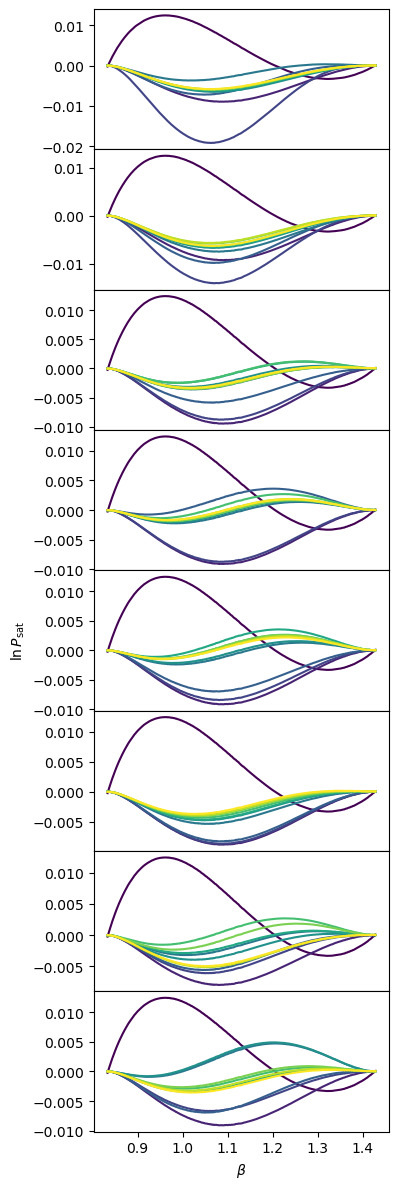

In [7]:
#Looking at how runs do with learing lnPsat over different iterations

betas = np.linspace(1/1.2, 1/0.7, 1000)

fig, ax = plt.subplots(len(run_dirs), figsize=(4.0, 1.5*len(run_dirs)))

for i, info in enumerate(active_info):
    plot_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(info['pred_mu'])))
    for j, pred in enumerate(info['pred_mu']):
        ax[i].plot(betas, (np.squeeze(pred) - gt_lnpsat(betas)), color=plot_colors[j])

ax[-1].set_xlabel(r'$\beta$')
ax[int(len(run_dirs)//2)].set_ylabel(r'$\ln P_\mathrm{sat}$')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

In [8]:
#To look at derivatives, load final GP model for each run
#Want to show that the mean function being linear does not just mean GP gives up and does nothing
gp_models = {}
for i, r in enumerate(run_dirs):
    this_gp_models = []
    for k, ind in enumerate([0, 1, 2, -1]):
        if ind >= 0:
            ind += 2
        else:
            k = ind
        this_data_list = load_data(r, active_info[i]['alpha'][:ind])
        this_params = active_info[i]['params'][k]
        this_gp_models.append(active_utils.create_GPR([dat.build_state() for dat in this_data_list],
                                                      start_params=this_params))
    gp_models['run%i'%(i+1)] = this_gp_models


2022-11-17 23:01:14.677590: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


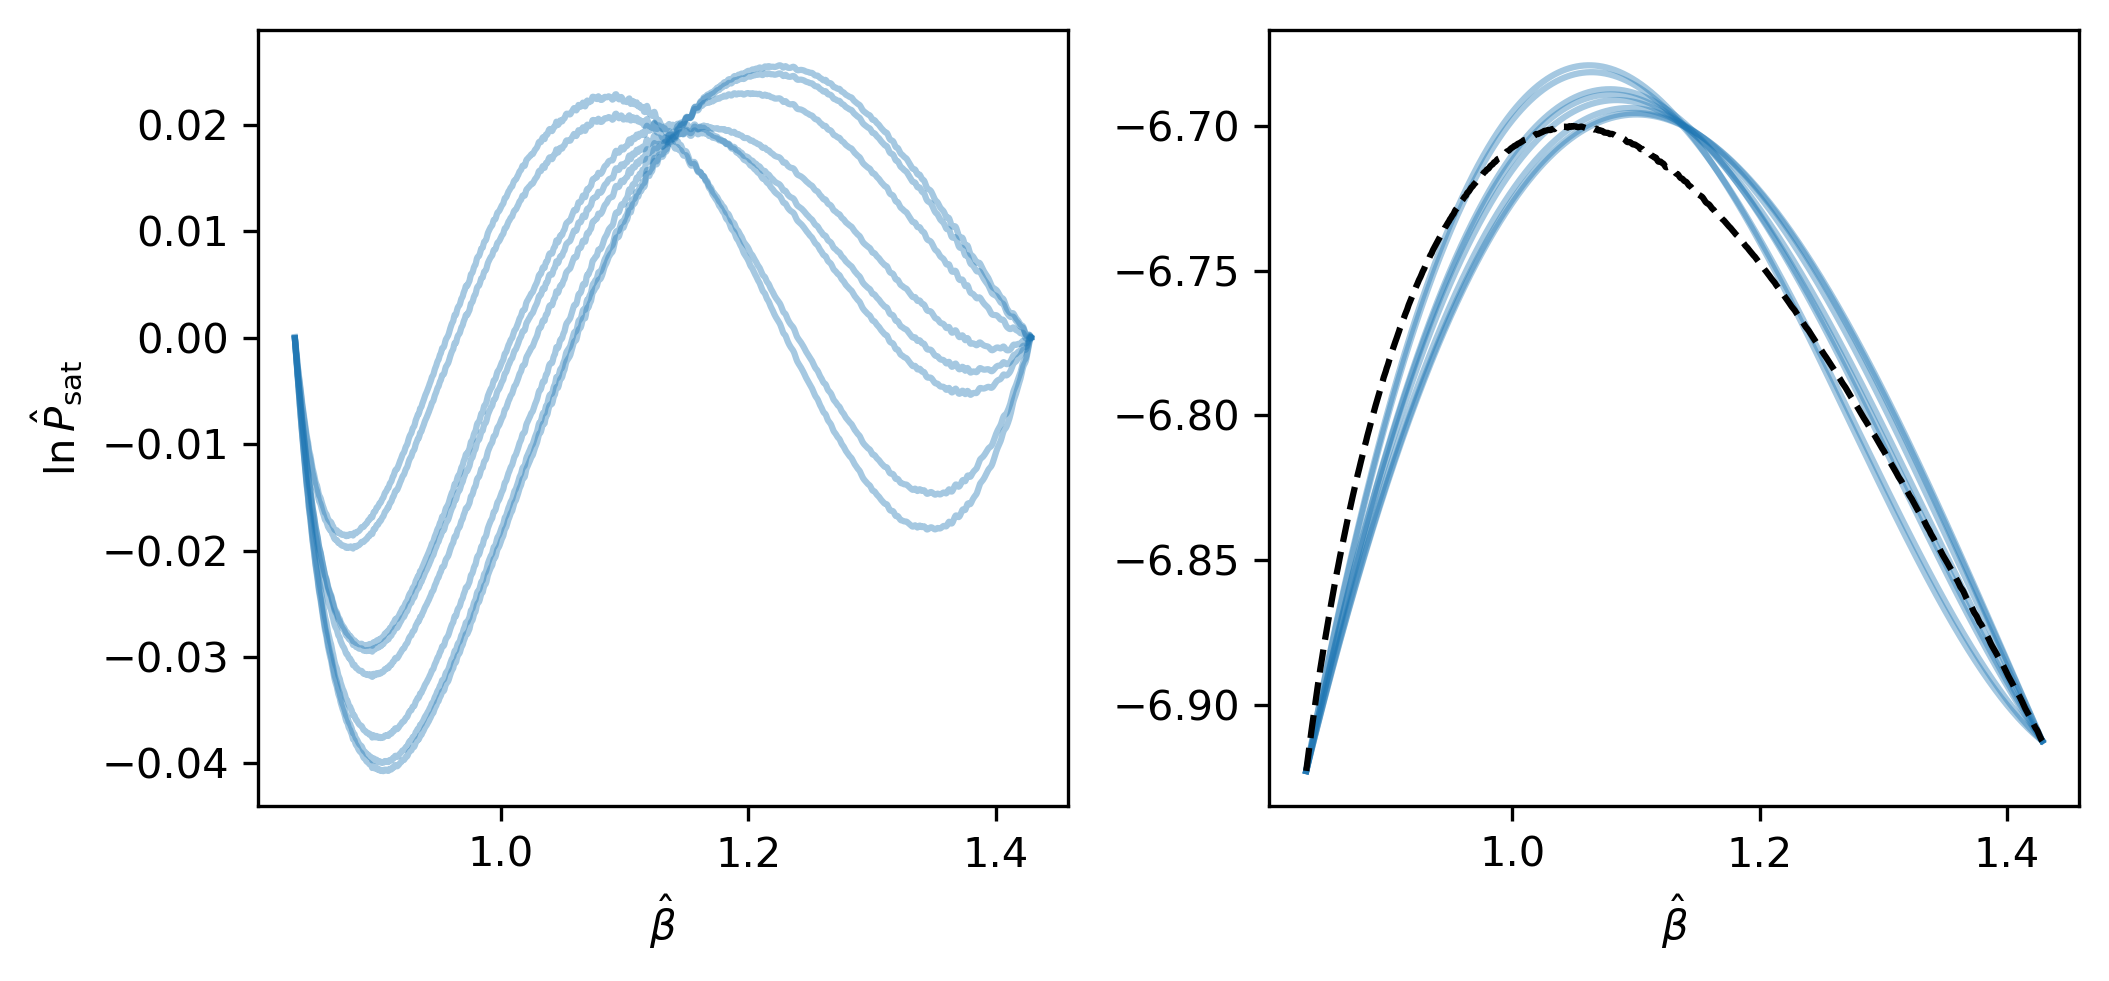

In [10]:
d_o = 1

betas = np.linspace(1/1.2, 1/0.7, 1000)

fig, ax = plt.subplots(1, 2, figsize=(7.13, 3.37), dpi=300)

for i in range(len(run_dirs)):
    gp = gp_models['run%i'%(i+1)][-1]
    x_input = np.vstack([betas, d_o*np.ones_like(betas)]).T
    gp_mu = np.squeeze(gp.predict_f(x_input)[0])
    if d_o == 0:
        gt_func = gt_lnpsat
    elif d_o == 1:
        gt_func = gt_dlnpsatdbeta
    else:
        gt_func = gt_lnpsat.derivative(d_o)
    ax[0].plot(betas,
               (gp_mu - gt_func(betas)),
               color='tab:blue', alpha=0.4)
    ax[1].plot(betas,
               gp_mu,
               color='tab:blue', alpha=0.4)
    if i == len(gp_models) - 1:
        ax[1].plot(betas, gt_func(betas), 'k--')

ax[0].set_xlabel(r'$\hat{\beta}$')
ax[1].set_xlabel(r'$\hat{\beta}$')
ax[0].set_ylabel(r'$\ln \hat{P}_\mathrm{sat}$')
# ax[0].set_ylabel(r'$\partial \ln \hat{P}_\mathrm{sat} / \partial \hat{\beta}$')

fig.tight_layout()

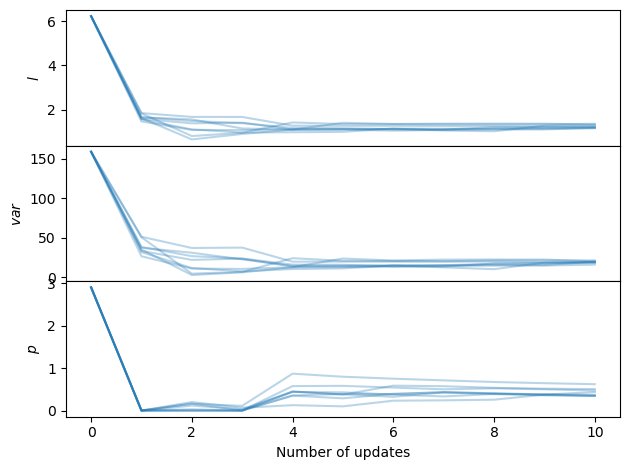

In [11]:
#Want to look at convergence of model parameters
fig, ax = plt.subplots(3, sharex=True, sharey=False)

for i, info in enumerate(active_info):
    this_params = info['params']
    for j in range(3):
        ax[j].plot(this_params[:, j], color='tab:blue', alpha=0.3)

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'$l$')
ax[1].set_ylabel(r'$var$')
ax[2].set_ylabel(r'$p$')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

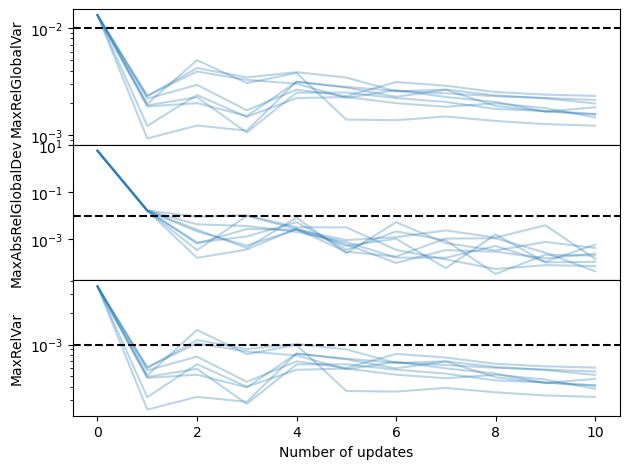

In [12]:
#Look at convergence of metrics (for stopping)
#Can look at those actually used/calculate, which are the max global relative quantities
#Then also look at just the max relative variance, which is what is used for adaptive integration
#Should maybe redo run so that matches? Or at least just add that in to computed metrics.
fig, ax = plt.subplots(3, sharex=True, sharey=False)

metric_relvar = active_utils.MaxRelVar(0.001)
metric_names = ['MaxRelGlobalVar', 'MaxAbsRelGlobalDeviation']

for i, info in enumerate(active_info):
    this_means = info['pred_mu']
    this_stds = info['pred_std']
    this_relvar = np.array([metric_relvar([this_means[:k+1], this_stds[:k+1]], None, None)
                            for k in range(this_means.shape[0])])
    for j, name in enumerate(metric_names):
        ax[j].plot(info[name], color='tab:blue', alpha=0.3)
    ax[2].plot(this_relvar, color='tab:blue', alpha=0.3)

ax[-1].set_xlabel(r'Number of updates')

ax[0].set_ylabel(r'MaxRelGlobalVar')
ax[1].set_ylabel(r'MaxAbsRelGlobalDev')
ax[2].set_ylabel(r'MaxRelVar')

ax[0].axhline(1e-02, color='k', linestyle='--')
ax[1].axhline(1e-02, color='k', linestyle='--')
ax[2].axhline(1e-03, color='k', linestyle='--')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

In [13]:
#Want to repeat (sort of) construction of GP models, but with GP models after just 2 updates
#After 1 update, learns that within tolerance over full interval
#So then on 2nd update, takes very large, space-filling step
#At that point, all metrics should register convergence, so emulating as if allow stopping criteria
#This is borne out by models where had stopping turned on
run_dirs_stop = sorted(glob.glob(os.path.expanduser('~/GPR_Extrapolation/LJ_EOS/NPT/with_stop/run*')))
active_info_stop = []
for r in run_dirs_stop:
    active_info_stop.append(np.load('%s/active_history.npz'%r))

In [14]:
gp_models_stop = []
for i, r in enumerate(run_dirs_stop):
    this_data_list = load_data(r, active_info_stop[i]['alpha'])
    this_params = active_info_stop[i]['params'][-1]
    gp_models_stop.append(active_utils.create_GPR([dat.build_state() for dat in this_data_list],
                                                  start_params=this_params))

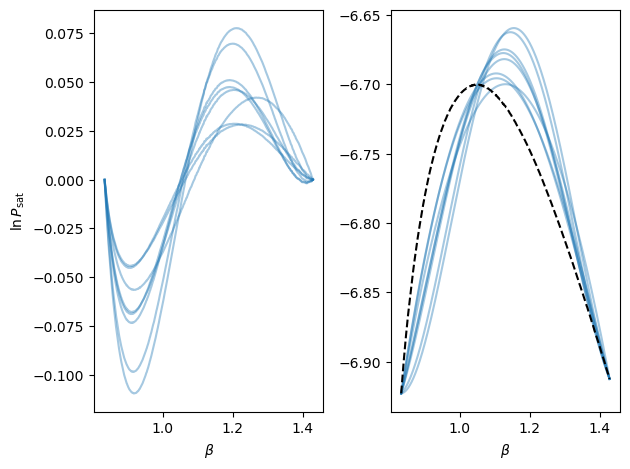

In [15]:
d_o = 1

betas = np.linspace(1/1.2, 1/0.7, 1000)

fig, ax = plt.subplots(1, 2)

for i, gp in enumerate(gp_models_stop):
    x_input = np.vstack([betas, d_o*np.ones_like(betas)]).T
    gp_mu = np.squeeze(gp.predict_f(x_input)[0])
    if d_o == 0:
        gt_func = gt_lnpsat
    elif d_o == 1:
        gt_func = gt_dlnpsatdbeta
    else:
        gt_func = gt_lnpsat.derivative(d_o)
    ax[0].plot(betas,
               (gp_mu - gt_func(betas)),
               color='tab:blue', alpha=0.4)
    ax[1].plot(betas,
               gp_mu,
               color='tab:blue', alpha=0.4)
    if i == len(gp_models) - 1:
        ax[1].plot(betas, gt_func(betas), 'k--')

ax[0].set_xlabel(r'$\beta$')
ax[1].set_xlabel(r'$\beta$')
ax[0].set_ylabel(r'$\ln P_\mathrm{sat}$')

fig.tight_layout()

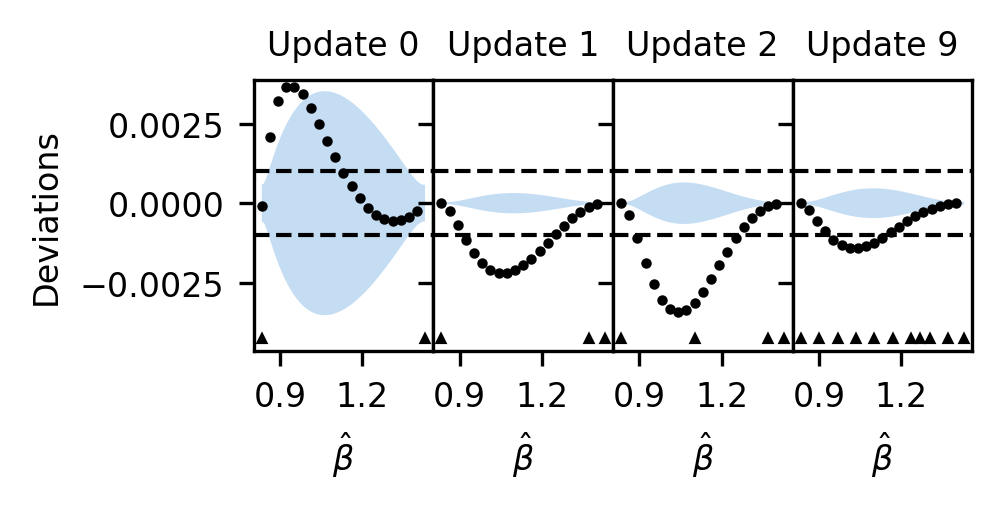

In [17]:
#Nice figure for main text
#In SI, can just show that lnPsat is linear in single figure
#And in SI, show deviations from ground truth for all runs
#But for main text, just use single run AND show where updates chosen to give sense of update strategy
#In SI, should also show GP fit to derivative
#Then also have a figure for the density (part of same figure, probably)
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(3.37, 1.8), dpi=300)

run_num = 2
run = 'run%i'%run_num

betas = np.linspace(1/1.2, 1/0.7, 1000)

compare_min = 0.0
compare_max = 0.0

for i in range(4):
    ax[i].axhline(-0.001, color='k', linestyle='--', linewidth=1.0)
    ax[i].axhline(0.001, color='k', linestyle='--', linewidth=1.0)
    
    this_gp = gp_models[run][i]
    x_input = np.vstack([betas, np.zeros_like(betas)]).T
    gp_mu, gp_var = this_gp.predict_f(x_input)
    gp_mu = np.squeeze(gp_mu)
    gp_std = np.sqrt(np.squeeze(gp_var))
    this_gt = gt_lnpsat(betas)
    this_dev = (gp_mu - this_gt) / np.abs(this_gt)
    ax[i].plot(betas[::50], this_dev[::50], 'ko', ms=1.5)
    ax[i].fill_between(betas,
                       -1.0*gp_std/np.abs(this_gt),
                       1.0*gp_std/np.abs(this_gt),
                       alpha=0.3)
    this_alpha = np.unique(this_gp.data[0][:, 0])
    
    #Use output to set plot range
    this_compare_min = np.min(-1.0*gp_std/np.abs(this_gt))
    this_compare_max = np.max(1.0*gp_std/np.abs(this_gt))
    if this_compare_min < compare_min:
        compare_min = this_compare_min
    if this_compare_max > compare_max:
        compare_max = this_compare_max
    
    ax[i].set_xlabel(r'$\hat{\beta}$', fontsize=8)
    ax[i].xaxis.set_major_locator(MaxNLocator(prune='both', nbins=2))
    ax[i].tick_params(axis='both', labelsize=8)
    if i == 3:
        ind = len(this_alpha) - 2
    else:
        ind = i
    ax[i].set_title('Update %i'%(ind), fontsize=8)

compare_range = compare_max - compare_min
ax[0].set_ylim((compare_min - 0.05*compare_range, compare_max + 0.05*compare_range))
#Plot points where collected data for GPR
y_lims = ax[0].get_ylim()
y_range = y_lims[1] - y_lims[0]
ax[0].set_ylim((y_lims[0] - 0.10*y_range, y_lims[1]))

for i in range(4):
    this_alpha = np.unique(gp_models[run][i].data[0][:, 0])
    ax[i].plot(this_alpha, (y_lims[0] - 0.05*y_range)*np.ones_like(this_alpha),
               marker='^', color='k', linestyle='', ms=1.5)

ax[0].set_ylabel('Deviations', fontsize=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

plt.show()

## Density

In [18]:
#Without stoppping
dens_info = []
for r in run_dirs:
    dens_info.append(np.load('%s/dens_model_info.npz'%r))


0.08146814841007104
0.02382989395091026
0.07794168590485616
0.017683357982904605
0.07484021111566473
0.019866124983505064
0.07895835796180614
0.020297522960749638
0.07959901168660638
0.020762556053626008
0.07904841590694697
0.019933819767033758
0.07368998119998298
0.016949399543905765
0.07972339904146308
0.02043863701946575


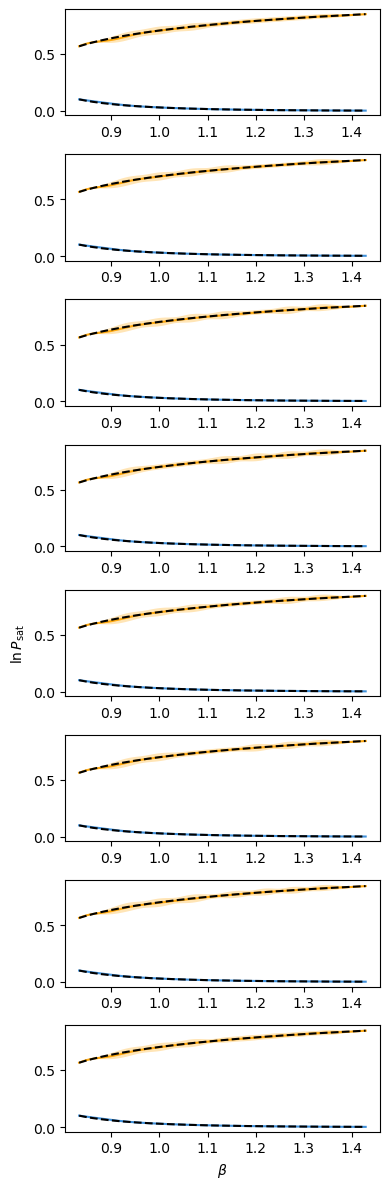

In [19]:
betas = np.linspace(1/1.2, 1/0.7, 1000)

fig, ax = plt.subplots(len(dens_info), figsize=(4.0, 1.5*len(run_dirs)))

for i, info in enumerate(dens_info):
    for j in range(2):
        ax[i].plot(betas, info['pred_mu'][:, j])
        ax[i].fill_between(betas,
                           info['pred_conf_int'][0, :, j],
                           info['pred_conf_int'][1, :, j],
                           alpha=0.3)
        ax[i].plot(betas, gt_dens[j](betas), 'k--')
        print(np.max(abs(info['pred_mu'][:, j] - gt_dens[j](betas))/abs(gt_dens[j](betas))))

ax[-1].set_xlabel(r'$\beta$')
ax[int(len(run_dirs)//2)].set_ylabel(r'$\ln P_\mathrm{sat}$')

fig.tight_layout()

In [20]:
#With stoppping
dens_info_stop = []
for r in run_dirs_stop:
    dens_info_stop.append(np.load('%s/dens_model_info.npz'%r))


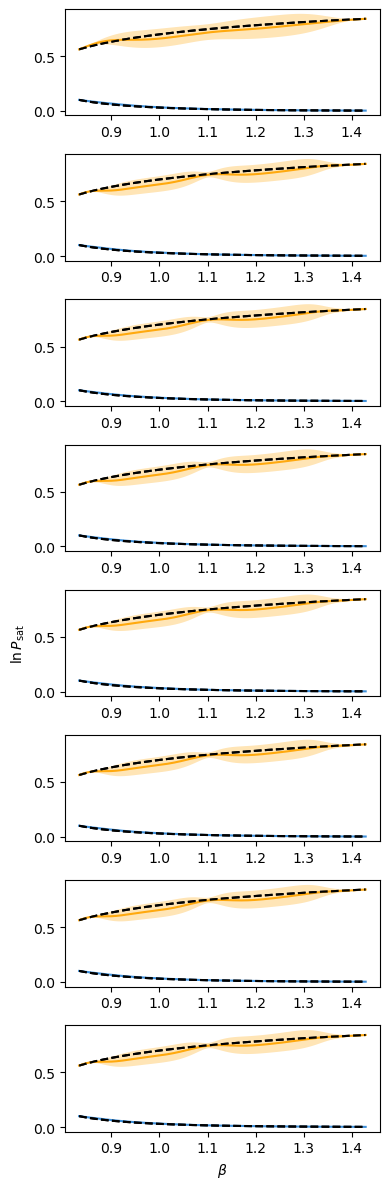

In [21]:
betas = np.linspace(1/1.2, 1/0.7, 1000)

fig, ax = plt.subplots(len(run_dirs_stop), figsize=(4.0, 1.5*len(run_dirs_stop)))

for i, info in enumerate(dens_info_stop):
    for j in range(2):
        ax[i].plot(betas, info['pred_mu'][:, j])
        ax[i].fill_between(betas,
                           info['pred_conf_int'][0, :, j],
                           info['pred_conf_int'][1, :, j],
                           alpha=0.3)
        ax[i].plot(raw_beta, raw_dens, 'k--')

ax[-1].set_xlabel(r'$\beta$')
ax[int(len(run_dirs_stop)//2)].set_ylabel(r'$\ln P_\mathrm{sat}$')

fig.tight_layout()

In [22]:
#Load gp models for density at different updates
dens_gp_models = {}
for i, r in enumerate(run_dirs):
    this_gp_models = []
    for k, ind in enumerate([0, 1, -1]):
        if ind >= 0:
            ind += 6
        this_input_x = dens_info[i]['input_x'][:ind, :]
        this_input_y = dens_info[i]['input_y'][:ind, :]
        this_input_cov = dens_info[i]['input_cov'][:, :ind, :ind]
        this_gp_models.append(DensityGPModel(this_input_x, this_input_y, this_input_cov))
        active_utils.train_GPR(this_gp_models[-1].gp, start_params=dens_info[i]['params'])

    dens_gp_models['run%i'%(i+1)] = this_gp_models

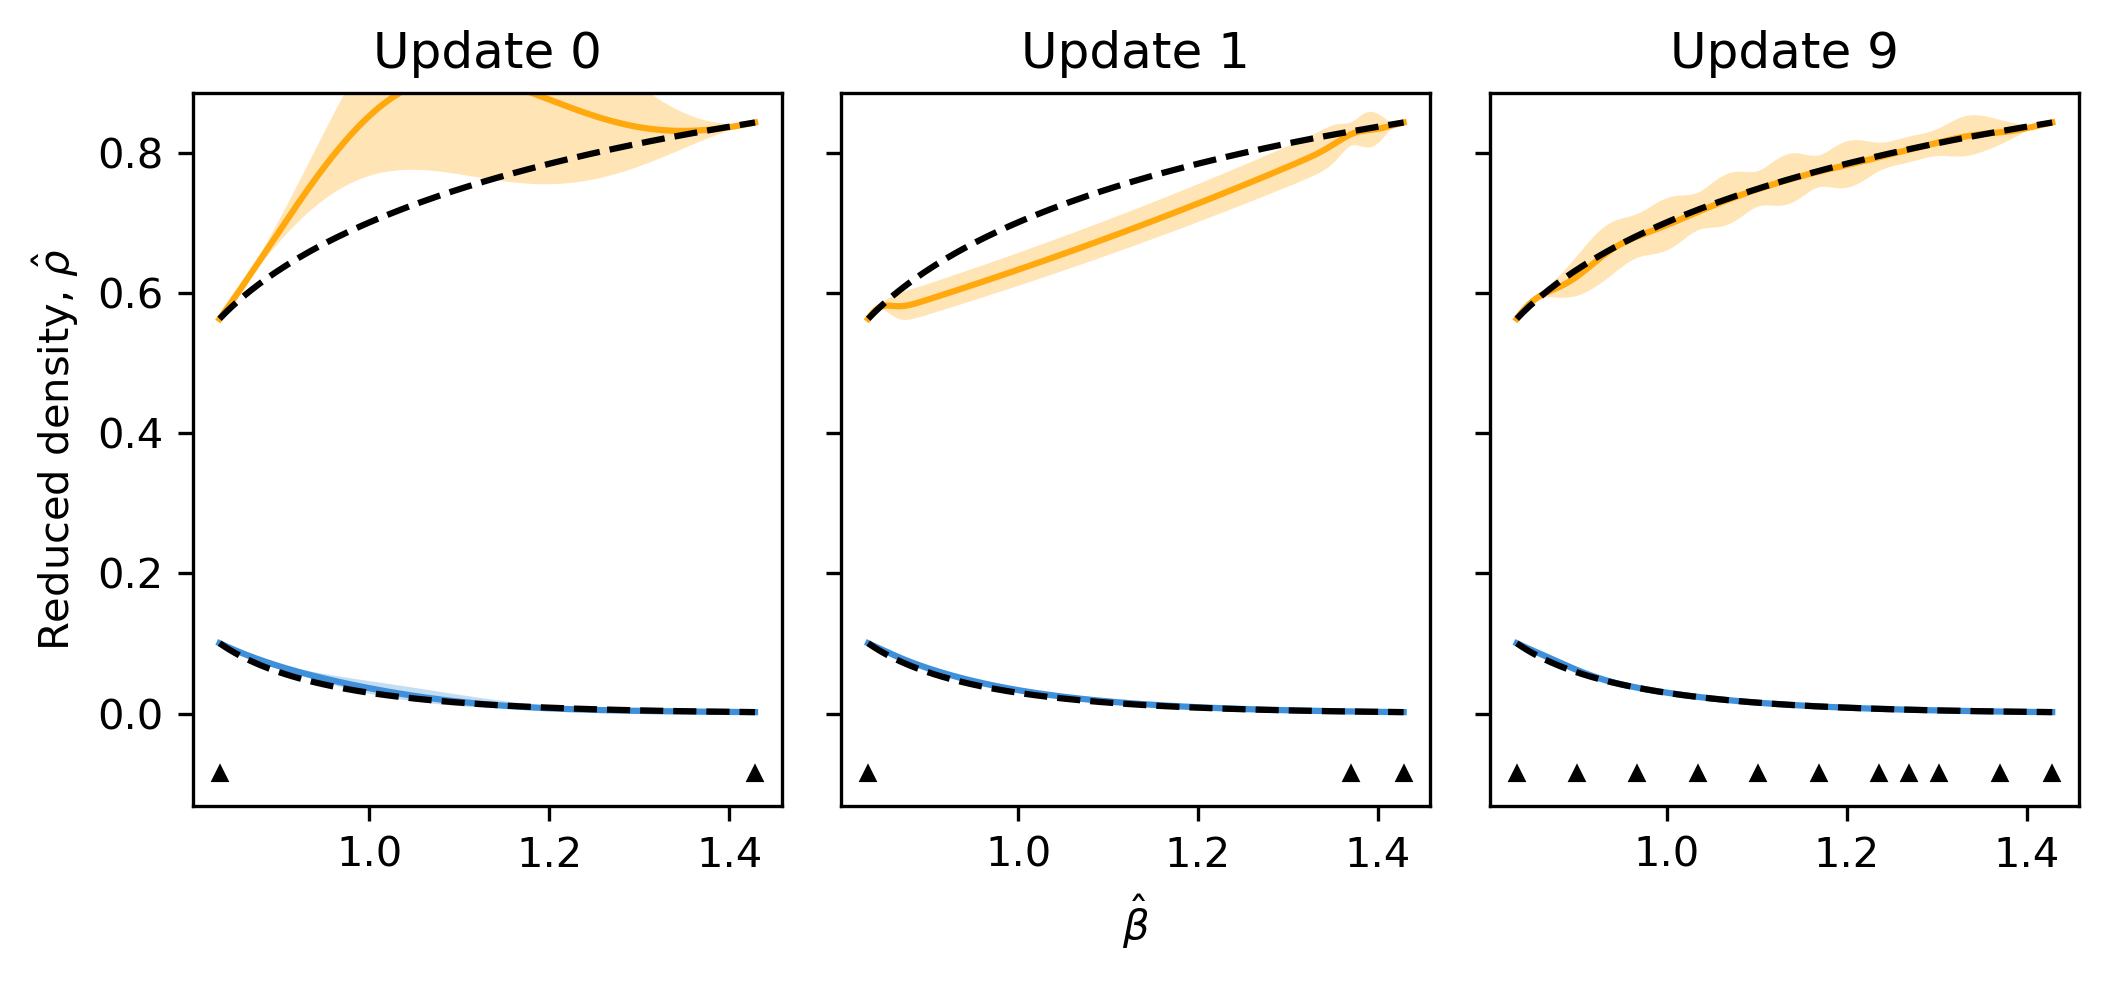

In [27]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(7.13, 3.37), dpi=300)

run_num = 1

betas = np.linspace(1/1.2, 1/0.7, 501)

#Use ground truth to set plot range
compare_min = np.min(raw_dens)
compare_max = np.max(raw_dens)
compare_range = compare_max - compare_min
ax[0].set_ylim((compare_min - 0.05*compare_range, compare_max + 0.05*compare_range))
#Plot points where collected data for GPR
y_lims = ax[0].get_ylim()
y_range = y_lims[1] - y_lims[0]
ax[0].set_ylim((y_lims[0] - 0.10*y_range, y_lims[1]))   

for i in range(3):
    this_gp = dens_gp_models[run][i]
    x_input = np.vstack([betas, np.zeros_like(betas)]).T
    gp_mu, gp_var = this_gp.gp.predict_f(x_input)
    gp_mu, gp_std, gp_conf_int = this_gp.transform_func(betas, gp_mu.numpy(), gp_var.numpy())
    gp_conf_int = np.array(gp_conf_int)
    
    for j in range(2):
        ax[i].plot(betas, gp_mu[:, j])
        ax[i].fill_between(betas,
                           gp_conf_int[0, :, j],
                           gp_conf_int[1, :, j],
                           alpha=0.3)
    ax[i].plot(raw_beta, raw_dens, 'k--')
    
    this_alpha = np.unique(this_gp.gp.data[0][:, 0])
    ax[i].plot(this_alpha, (y_lims[0] - 0.05*y_range)*np.ones_like(this_alpha),
               marker='^', color='k', linestyle='', ms=3.0)

ax[0].set_title('Update 0')
ax[1].set_title('Update 1')
ax[2].set_title('Update 9')

ax[1].set_xlabel(r'$\hat{\beta}$')
ax[0].set_ylabel(r'Reduced density, $\hat{\rho}$')

fig.tight_layout()